# stixdcpy 


stixdcpy is a Python package designed to simplify the retrieval and analysis of STIX data. It offers convenient APIs for querying and downloading data from the STIX data center (https://datacenter.stix.i4ds.net/), as well as a collection of tools for visualizing data and conducting typical analysis tasks. stixdcpy empowers users to effortlessly retrieve and download various types of data from the STIX data center, including:

* Quick-look light curves
* Housekeeping data
* Science data
* Energy calibration data
* Auxiliary data
* STIX solar flare list
* STIX operations events
* Ephemeris data

# Installation


```sh
pip install git+https://github.com/i4ds/stixdcpy.git
```


# Tutorial and documentation

- [Tutorial](https://github.com/i4ds/stixdcpy/blob/master/examples/tutorial.ipynb)
- [Documentation](https://i4ds.github.io/stixdcpy/)



#  Cite this work
If you use the stixdcpy in your research and publications, we would definitely appreciate an appropriate acknowledgment and citation! We suggest the following BibTex:
* [1] STIX data center paper published on A&A: https://doi.org/10.1051/0004-6361/202346031
* [2] Hualin Xiao, Säm Krucker, Lastufka Erica, & William Setterberg. (2022). stixdcpy – a python package that facilitates access and analysis of STIX data (v2.0). Zenodo. https://doi.org/10.5281/zenodo.7180433

# Reporting Issues and Contributing
Open an issue on GitHub to report a problem. Pull requests welcome.




In [1]:

import numpy as np
import pandas as pd

from pprint import pprint
from datetime import timedelta
from matplotlib import pyplot as plt
from astropy.table import QTable
from stixdcpy.quicklook import LightCurves
from stixdcpy.energylut import EnergyLUT
from stixdcpy import auxiliary as aux
from stixdcpy.net import FitsQuery as fq
from stixdcpy.net import Request as jreq
from stixdcpy import instrument as inst
from stixdcpy.science import PixelData, Spectrogram, spec_fits_crop, spec_fits_concatenate, fits_time_to_datetime
from stixdcpy.housekeeping import Housekeeping
from astropy.io import fits
from stixdcpy import detector_view as dv
from stixdcpy import spectrogram  as cspec
from stixdcpy.imgspec import ImgSpecArchive as isar
#from google.colab import data_table
#data_table.enable_dataframe_formatter()
%matplotlib notebook

# Request Quick-look  data from STIX data center 

Let's download some light curves from STIX data center

In [2]:
lc = LightCurves.from_sdc(start_utc='2023-07-16T02:00:00', end_utc='2023-07-16T10:00:00', ltc=True)


where: 
* start_utc -  start time (onboard time); 
* end_utc - end time ; 
* ltc - an optional argument.  Perform light time correction to light curves if it is True

It returns a data object



Preview the QL lightcurves

<IPython.core.display.Javascript object>


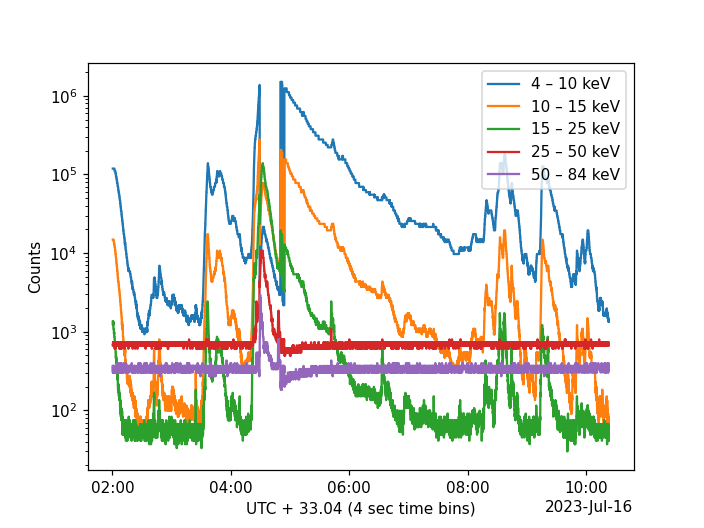

<AxesSubplot:xlabel='UTC + 33.04 (4 sec time bins)', ylabel='Counts'>

In [3]:
lc.peek()

Access the data:

In [4]:
#the attribute data is a python dictionary
lc.data.keys()


dict_keys(['cqllc', 'rcr', 'triggers', 'energy_bins', 'num', 'start_unix', 'start_utc', 'end_unix', 'end_utc', 'light_time_diff', 'solo_to_earth_light_time', 'is_light_time_corrected', 'delta_time', 'counts'])

In [5]:
#print(lc.cqllc)

<IPython.core.display.Javascript object>


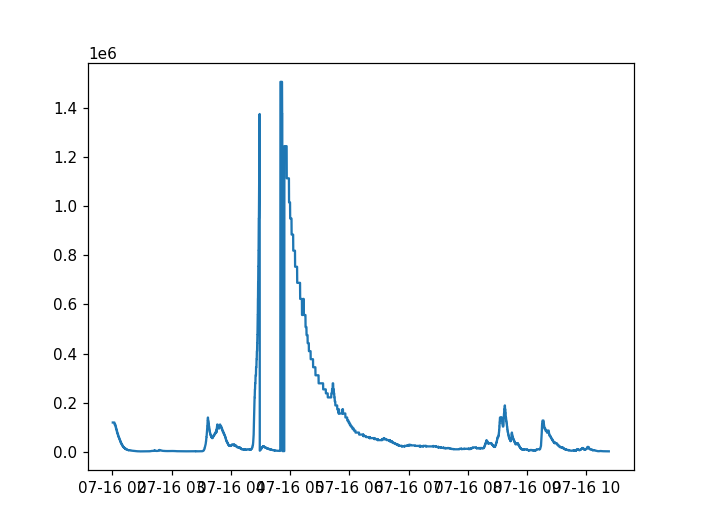

In [6]:
fig=plt.figure()
plt.plot(lc.time, lc.counts[0,:])

# Housekeep data

Fetching housekeeping data from STIX data center:



In [7]:
hk=Housekeeping.from_sdc(start_utc='2021-09-06T12:00:00', end_utc='2021-09-06T14:00:00')
pprint(hk.param_names)


{'NIX00020': 'SID',
 'NIX00072': 'Med value of trig acc',
 'NIX00073': 'Max value of trig acc',
 'NIX00076': 'Attenuator motions',
 'NIX00078': 'HK_ASP_PHOTOA0_V',
 'NIX00079': 'HK_ASP_PHOTOA1_V',
 'NIX00080': 'HK_ASP_PHOTOB0_V',
 'NIX00081': 'HK_ASP_PHOTOB1_V',
 'NIX00085': 'FDIR function status',
 'NIX00094': 'Attenuator currents',
 'NIXD0001': 'SW Version Number',
 'NIXD0002': 'CPU load',
 'NIXD0003': 'Archive Memory usage',
 'NIXD0004': 'IDPU identifier',
 'NIXD0005': 'Active SPW link',
 'NIXD0021': 'SW running',
 'NIXD0022': 'Instrument number',
 'NIXD0023': 'Instrument mode',
 'NIXD0024': 'HK_PSU_TEMP_T',
 'NIXD0025': 'HK_DPU_PCB_T',
 'NIXD0026': 'HK_DPU_FPGA_T',
 'NIXD0027': 'HK_DPU_3V3_C',
 'NIXD0028': 'HK_DPU_2V5_C',
 'NIXD0029': 'HK_DPU_1V5_C',
 'NIXD0030': 'HK_DPU_SPW_C',
 'NIXD0031': 'HK_DPU_SPW0_V',
 'NIXD0032': 'HK_DPU_SPW1_V',
 'NIXD0035': 'HK_DPU_1V5_V',
 'NIXD0036': 'HK_REF_2V5_V',
 'NIXD0037': 'HK_DPU_2V9_V',
 'NIXD0038': 'HK_ASP_REF_2V5A_V',
 'NIXD0039': 'HK_ASP_REF_

Plot housekeeping data time series:

<IPython.core.display.Javascript object>


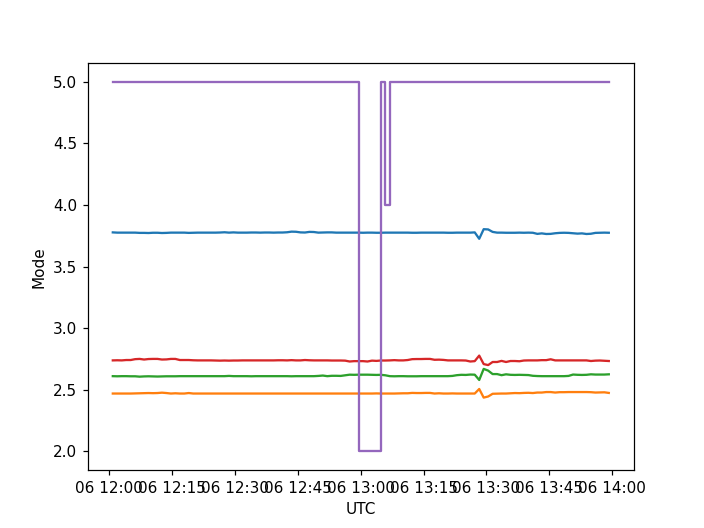

<AxesSubplot:xlabel='UTC', ylabel='Value'>

In [8]:
hk.plot('NIX00078,NIX00079,NIX00080,NIX00081')


You need to provide the names of parameters to be plotted.

One could also plot time series of parameters using plt

In [9]:
plt.step( hk.data['datetime'], hk.data['raw_values']['NIXD0023'])
plt.xlabel('UTC')
plt.ylabel('Mode')

Text(0, 0.5, 'Mode')

# Calibration data

Request calibration data from STIX data center

In [10]:
elut=EnergyLUT.request('2021-09-03T00:00:00')

Print information on the onboard elut and the calibration run peformed closest to the specified time:

In [11]:
elut.info()


{'calibration_run': {'duration': 86400,
                     'obs_begin': '2021-09-02T12:56:17.958',
                     'run_id': 1353},
 'onboard_elut': {'upload_time_range': ['2021-06-25T14:54:14.456',
                                        '2021-06-25T14:55:49.456']}}


Print energy calibration factors 

In [12]:
#print the data
#elut.data

Print the real energy range of bins of a pixel

In [13]:
lut=elut.get_pixel_true_ebins(pixel=34)

pd.DataFrame(lut)

,0,1
0,0.007,3.998
1,3.998,4.996
2,4.996,5.993
3,5.993,6.991
4,6.991,7.989
5,7.989,8.987
6,8.987,9.984
7,9.984,10.982
8,10.982,11.980
9,11.980,12.978


# S/C Ephemeris 

Fetch s/c ephemeris data from STIX data center: 

In [14]:
emph=aux.Ephemeris.from_sdc(start_utc='2022-01-01T00:00:00', end_utc='2022-03-31T01:00:00', steps=100)

Preview the data

<IPython.core.display.Javascript object>


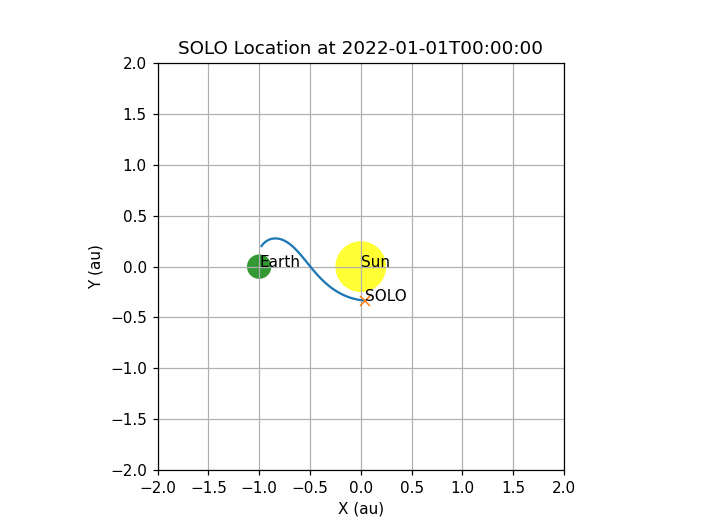

<AxesSubplot:title={'center':'SOLO Location at 2022-01-01T00:00:00'}, xlabel='X (au)', ylabel='Y (au)'>

In [15]:
emph.peek()

In [16]:
#Print the data
#pprint(emph.data['orbit'])

# STIX pointing

<IPython.core.display.Javascript object>


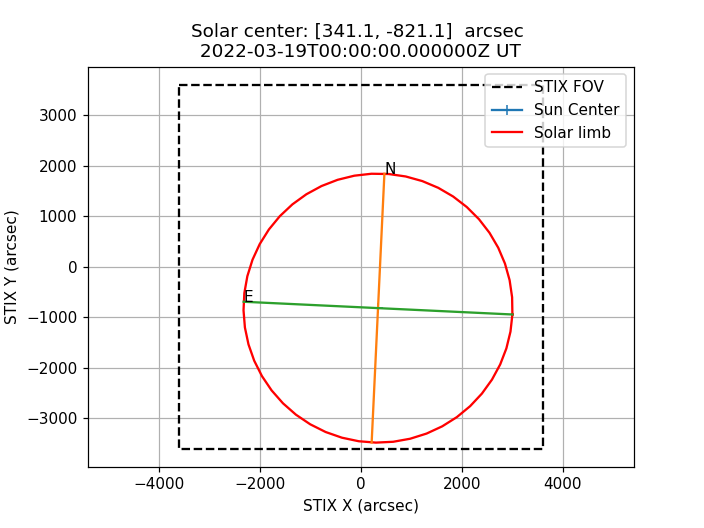

<AxesSubplot:title={'center':'Solar center: [341.1, -821.1]  arcsec \n 2022-03-19T00:00:00.000000Z UT '}, xlabel='STIX X (arcsec)', ylabel='STIX Y (arcsec)'>

In [17]:
fov=aux.Pointing.from_sdc('2022-03-19T00:00:00')
fov.peek()


The web tool at the link https://datacenter.stix.i4ds.net/view/ancillary provides more detailed information of STIX pointing

In [18]:
#Let's plot the data
#pprint(fov.data)

# Solar flare light time difference and viewing angle calculator

This tool allows calculation of the light time difference between a flare and observers at earth or solar orbiter, as well as the viewing angles. 

In [19]:
flare_aux=jreq.request_flare_light_time_and_angle(utc='2023-01-01T00:00:00', flare_x=100, flare_y=1000, observer='stix')
pprint(flare_aux)

{'error': 'No enough Auxiliary data to complete the calculation or invalid '
          'inputs!'}


where:        

* utc -    observation time
* flare_x -  flare helio-projective longitude in units of arcsec as seen by the observer 
* flare_y -  flare helio-projective latitude in units of arcsec 
* observer: It can be either "earth" or "stix" . The default value is "earth". 

A data object is returnned


The tool is available at the link
https://datacenter.stix.i4ds.net/view/ancillary


# Access and preview science data

## Pixel data


Let's download a  pixel data file from STIX data center

In [20]:
l1_obj=PixelData.from_sdc(request_id=2208270251, level='L1')

2022-08-27T04:06:57.455
2021-12-09T14:00:00


Here **2112240046** is the requests ID (also called unique id), which can  can be found on the science data web page https://datacenter.stix.i4ds.net/view/list/bsd.   
**ltc** is an optional argument. Light time correction will be performed if ltc = True. 
**l1_obj** is a data object 

Access the FITS Header Data Unit List attached to the data object:

In [21]:
hdul=l1_obj.hdul
hdul.info()

Filename: /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1_stix-sci-xray-cpd_20220827T040657-20220827T040815_V01_2208270251-65418.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   ()      
  1  CONTROL       1 BinTableHDU    103   1R x 12C   ['I', 'I', 'J', '141I', 'B', '141I', '98A', '73A', '3B', '3B', '33B', 'D']   
  2  DATA          1 BinTableHDU    113   78R x 12C   ['J', 'J', 'B', '12B', '32B', 'B', 'B', '16I', '16E', '6912B', '6912E', 'B']   
  3  IDB_VERSIONS    1 BinTableHDU     36   1R x 3C   [7A, D, D]   
  4  ENERGIES      1 BinTableHDU     36   27R x 3C   ['B', 'E', 'E']   


Note that FITS hdul is only one of the data attributes.  

Let's print the hdul header

In [22]:
hdul['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
FILENAME= 'solo_L1_stix-sci-xray-cpd_20220827T040657-20220827T040815_V01_22082&'
CONTINUE  '70251-65418.fits&'                                                   
CONTINUE  '' / FITS filename                                                    
RAW_FILE= 'LTP09_T09PM_req_BatchRequest.PktTmRaw.SOL.0.2022.303.08.54.21.000.V&'
CONTINUE  'zmi@2022.323.21.00.00.726.2.xml&'                                    
CONTINUE  '' / Raw filename(s)                                                  
PARENT  = 'solo_L0_stix-sci-xray-cpd_0714888282-0714888360_V01_2208270251-6541&'
CONTINUE  '8.fits&'                                                             
CONTINUE  '' / Source file c

Preview science data 

2022-08-27T04:06:57.455
2021-12-09T14:00:00


<IPython.core.display.Javascript object>


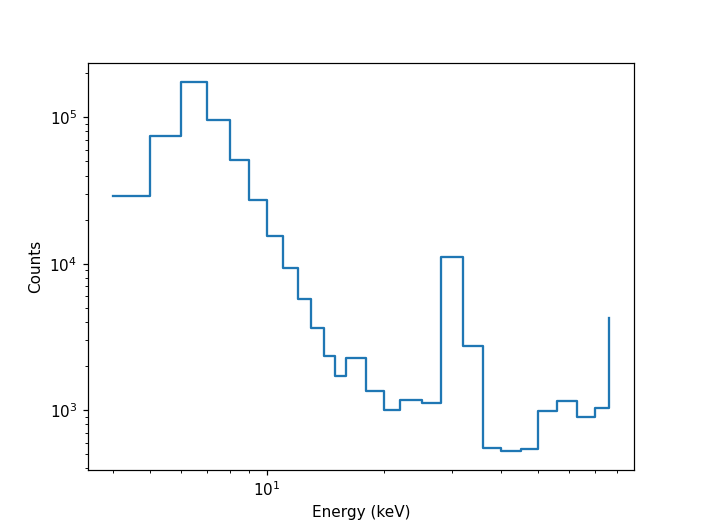

<IPython.core.display.Javascript object>


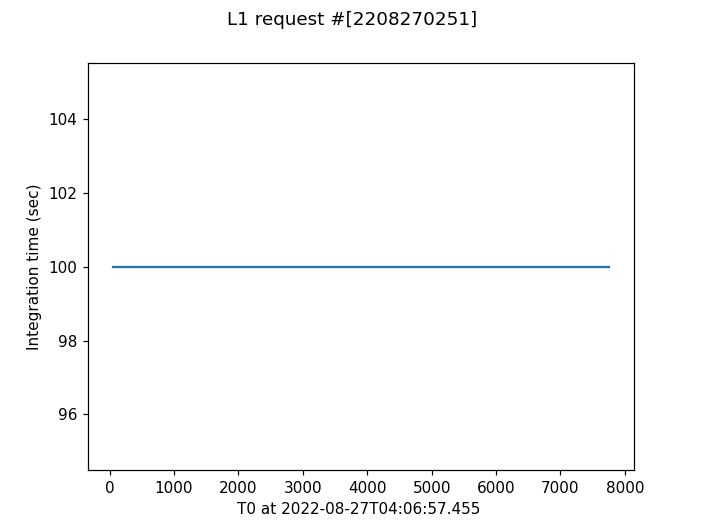

(None,
 None,
 <AxesSubplot:xlabel='Energy (keV)', ylabel='Counts'>,
 <AxesSubplot:xlabel='T0 at 2022-08-27T04:06:57.455 ', ylabel='Integration time (sec)'>)

In [23]:
l1_obj.peek('spec,tbin, qllc, lc')


Peform dead time correction to the data

In [24]:
corrected_data=l1_obj.correct_dead_time()

Print the array dimensions

In [25]:
corrected_data.keys()
for key, value in corrected_data.items():
    print(key, value.shape)

corrected_rates (78, 32, 8, 27)
count_rate (78, 32, 8, 27)
photons_in (78, 16)
live_ratio (78, 32)
live_error (78, 32)


Plot the live ratios of detectors: 

<IPython.core.display.Javascript object>


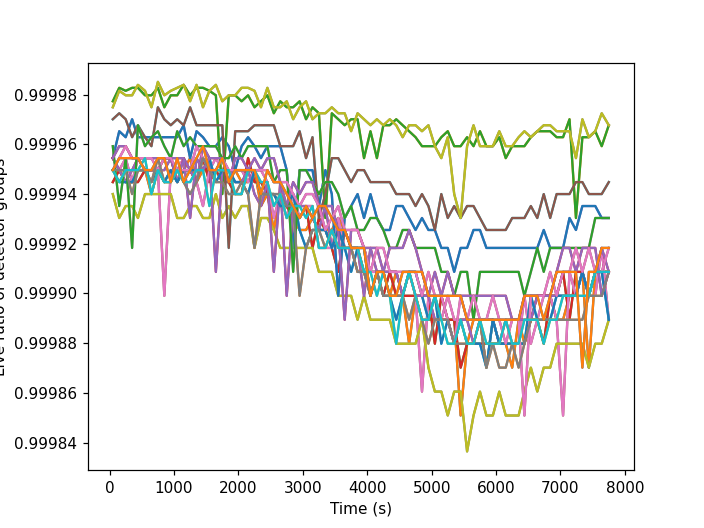

Text(0, 0.5, 'Live ratio of detector groups')

In [26]:
plt.figure()
plt.plot(l1_obj.time, corrected_data['live_ratio'])
plt.xlabel('Time (s)')
plt.ylabel('Live ratio of detector groups')

Plot pixel and energy integerated corrected count rate:

<IPython.core.display.Javascript object>


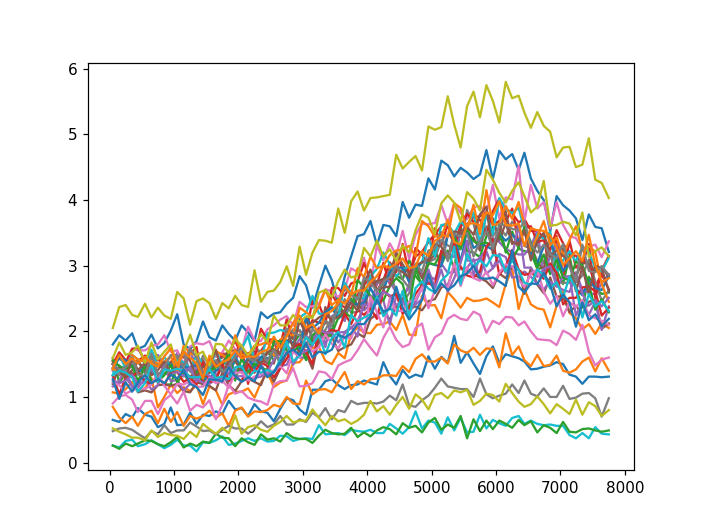

In [27]:
plt.figure()
plt.plot(l1_obj.time, np.sum(corrected_data['corrected_rates'], axis=(2,3) ))


Visualize counts with the module DetectorView

In [28]:
#dv.DetectorView?
big_pixel_counts = l1_obj.pixel_total_counts
small_pixel_counts=np.zeros((32,4))
total_counts=np.hstack( (big_pixel_counts, small_pixel_counts))

d = dv.DetectorView()
d.plot(total_counts)
d.save('dv.html')


Saved to dv.html. One can open it with a web browser and export it to SVG format


In [29]:
l1_obj.ebins_high

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 18.,
       20., 22., 25., 28., 32., 36., 40., 45., 50., 56., 63., 70., 76.,
       84.], dtype=float32)

In [30]:
#print(l1_obj.url)
#link to science browser 

## Download and plot spectrograms

Let's fetch a spectrogram data file from STIX data center

In [31]:
request_id=	2210223333
l4d=Spectrogram.from_sdc(request_id=request_id, level='L1')


2022-10-22T23:05:07.737
2021-12-09T14:00:00


Filename: /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1_stix-sci-xray-spec_20221022T230507-20221023T051017_V01_2210223333-49469.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  CONTROL       1 BinTableHDU    111   1R x 13C   ['I', 'I', 'J', '65I', 'B', '65I', '98A', '74A', '3B', '3B', '32B', '33B', 'D']   
  2  DATA          1 BinTableHDU     90   7015R x 9C   ['J', 'J', 'I', 'B', '12B', 'E', '32I', '32E', 'B']   
  3  IDB_VERSIONS    1 BinTableHDU     36   1R x 3C   [7A, D, D]   
  4  ENERGIES      1 BinTableHDU     36   32R x 3C   ['B', 'E', 'E']   


<IPython.core.display.Javascript object>


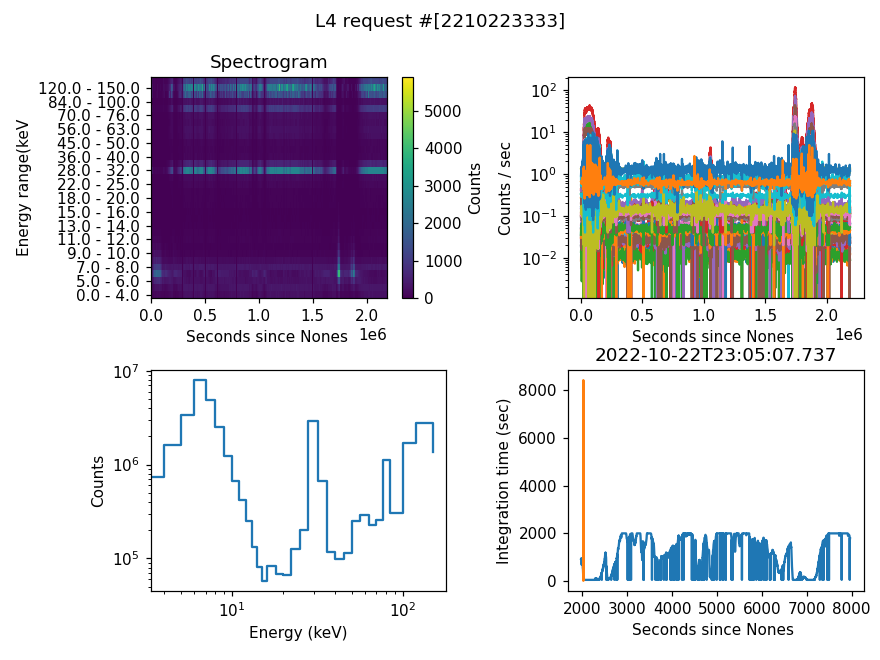

(<Figure size 800x600 with 5 Axes>,
 ((<AxesSubplot:title={'center':'Spectrogram'}, xlabel='Seconds since Nones ', ylabel='Energy range(keV'>,
   <AxesSubplot:xlabel='Seconds since Nones ', ylabel='Counts / sec'>),
  (<AxesSubplot:xlabel='Energy (keV)', ylabel='Counts'>,
   <AxesSubplot:xlabel='Seconds since Nones ', ylabel='Integration time (sec)'>)))

In [32]:
l4d.hdul.info()
l4d.peek()

## Crop or combine spectrograms

To select a shorter time interval from a long-duration spectrogram, or to combine two spectrograms into a single FITS file

In [33]:
plt.plot(l4d.datetime, np.sum(l4d.counts[:,4:10],axis=1))
plt.title(l4d.T0_utc)

Text(0.5, 1.0, '2022-10-22T23:05:07.737')

In [34]:
tstart = '2022-10-22T23:06:00'
tend = '2022-10-22T23:15:00'

In [35]:
#cropped_file = spec_fits_crop(l4d.filename, tstart, tend)

A new file containing the cropped spectrogram has been created. It can be accessed at its location:

In [36]:
#cropped_file

In [37]:
#cropped_spec = Spectrogram(cropped_file, None)
#plt.plot(cropped_spec.datetime, np.sum(cropped_spec.counts[:,4:10],axis=1))
#plt.title(cropped_spec.T0_utc)

Similarly, two spectrogram files can be combined, and simultaneously cropped to a particular time range if desired.

In [38]:
spec_res=fq.query('2022-04-19T20:00:00', '2022-04-19T23:00:00', product_type='xray-spec')
file_locations = spec_res.fetch()

In [39]:
tstart='2022-04-19T20:05:00'
combined_file = spec_fits_concatenate(file_locations[0], file_locations[1], tstart=tstart)

/home/xiaohl/.local/lib/python3.10/site-packages/stixdcpy/science.py:958: UserWarning: Gap of 0.038s between spectrogram files /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204199624_20220419T142011-20220419T202506_056955_V01.fits and /home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204198941_20220419T202506-20220420T023014_056956_V01.fits
  warnings.warn(


A new file containing the combined spectrogram has been created. It can be accessed at its location:

In [40]:
combined_file

'/home/xiaohl/FHNW/STIX/gsw/sdcpy/examples/downloads/solo_L1A_stix-sci-spectrogram-2204199624_20220419T142011-20220419T202506_056955_V01_200500_023014.fits'

In [41]:
with fits.open(combined_file) as f:
    primary, _, data, _ = f
    spectimes = fits_time_to_datetime(primary.header, data.data)
    plotdata = np.sum(data.data.counts[:,4:10],axis=1)

In [42]:
#import matplotlib.dates as mdates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.plot(spectimes.datetime,plotdata)
#plt.gcf().autofmt_xdate()
#plt.title(spectimes[0].isot)

In [43]:
spec = cspec.Spectrogram.from_sdc('2022-03-23T04:14:00', '2022-03-23T04:41:00')

<IPython.core.display.Javascript object>


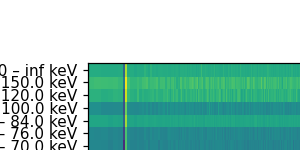

In [44]:
spec.peek()

# Search and download FITS files from STIX data center

Set download location

In [45]:
fq.chdir('./downloads')



In [46]:
res=fq.query('2022-02-10T05:00:00', '2022-02-18T07:00:00', product_type='xray-cpd',filter='BKG', level='L1')


Arguments: 
* **product_type**   options:  


| option        	| Data type             	|
|--------------	|----------------------	|
| any      	| Any type (default value)          	|
| science      	| Any science          	|
| quicklook    	| Any quick-look       	|
| housekeeping 	| Housekeeping         	|
| xray-rpd     	| Raw pixel data       	|
| xray-cpd     	| Pixel data           	|
| xray-scpd    	| Summed pixel data    	|
| xray-vis     	| Visibility           	|
| xray-spec    	| Spectrogram          	|
| ql-lc        	| QL light curve       	|
| ql-var       	| QL variance          	|
| ql-bkg       	| QL background        	|
| ql-spec      	| QL spectra           	|
| ql-ffl       	| QL flare location    	|
| ql-cal       	| Calibration spectrum 	|
| aspect       	| Bulk aspect          	|
| auxiliary    	| Auxiliary data       	|


* filter: optional. 
    - Use to filter FITS files. Only science data with descriptions containing the specified string will be selected. 
    set it to None if you  don't want to filter the results



An instance of FitQueryResult  is returned. 



Convert the query result to pandas dataframe: 


In [47]:
df=res.to_pandas()
df


,url,observation_time_range,file_id,unique_id,product_type,product_group,level,detector_mask,pixel_mask,energy_range_keV,eunit,time_bin,duration
0,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-10T14:21:05.450, 2022-02-10T15:14:25....",278749,2202100022,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,3200,3200
1,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-11T21:16:24.342, 2022-02-11T22:52:24....",278798,2202110024,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,5760,5760
2,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-12T10:48:09.626, 2022-02-12T12:34:49....",278826,2202120010,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,6400,6400
3,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-12T19:39:53.780, 2022-02-12T21:26:33....",278831,2202120011,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,6400,6400
4,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-13T17:08:47.514, 2022-02-13T18:17:27....",278874,2202130021,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,6272,4118
5,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-13T00:08:47.608, 2022-02-13T00:56:47....",278852,2202130022,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,2880,2880
6,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-15T07:04:11.649, 2022-02-15T07:52:11....",278961,2202150022,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,2880,2880
7,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-16T09:21:15.109, 2022-02-16T10:57:15....",279007,2202160007,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,5760,5760
8,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-16T19:10:11.170, 2022-02-16T20:46:11....",279011,2202160008,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,5760,5760
9,http://datacenter.stix.i4ds.net/download/fits/...,"[2022-02-17T17:25:00.206, 2022-02-17T19:01:00....",279035,2202170001,xray-cpd,science,L1,0xFFFFFFFF,0xFFF,"[4.0, Infinity]",1,5760,5760


One could download all the FITS file from stix data center by using the function "fetch": 

In [48]:
fits_list=res.fetch()

Note that if a FITS file is found on the local disk, it will not be downloaded again from STIX data center. 

Open all the download FITS file: 

In [49]:
hduls=res.open_fits()


hduls is a list of hdu objects

Print file info

In [50]:
res.fits_info()

Filename: downloads/solo_L1_stix-sci-xray-cpd_20220210T142105-20220210T151425_V01_2202100022-58537.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   ()      
  1  CONTROL       1 BinTableHDU    103   1R x 12C   [I, I, J, 4I, B, 4I, 98A, 73A, 3B, 3B, 33B, D]   
  2  DATA          1 BinTableHDU    115   1R x 12C   [J, J, B, 12B, 32B, B, B, 16J, 16E, 11904I, 11904E, B]   
  3  IDB_VERSIONS    1 BinTableHDU     36   1R x 3C   [7A, D, D]   
  4  ENERGIES      1 BinTableHDU     36   31R x 3C   [B, E, E]   
Filename: downloads/solo_L1_stix-sci-xray-cpd_20220211T211624-20220211T225224_V01_2202110024-58551.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   ()      
  1  CONTROL       1 BinTableHDU    103   1R x 12C   [I, I, J, 4I, B, 4I, 98A, 73A, 3B, 3B, 33B, D]   
  2  DATA          1 BinTableHDU    115   1R x 12C   [J, J, B, 12B, 32B, B, B, 16J, 16E, 11904I, 11904E, B]   
  3 

# Download flare list from STIX data center

In [51]:
flares=jreq.fetch_flare_list('2021-04-08T00:00:00', '2021-04-12T00:00:00', sort='goes')
#one can print the data
pprint(flares)

[{'CFL_X_arcsec': None,
  'CFL_Y_arcsec': None,
  'GOES_class': 'A',
  'GOES_flux': 4.573380252281822e-08,
  'LC0_BKG': 248.88783955129534,
  'LC0_BKG_COUNTS_4S': 247.0,
  'LC0_PEAK_COUNTS_4S': 335,
  'LC1_BKG_COUNTS_4S': 49.0,
  'LC1_PEAK_COUNTS_4S': 67,
  'LC2_BKG_COUNTS_4S': 67.0,
  'LC2_PEAK_COUNTS_4S': 91,
  'LC3_BKG_COUNTS_4S': 863.0,
  'LC3_PEAK_COUNTS_4S': 927,
  'LC4_BKG_COUNTS_4S': 463.0,
  'LC4_PEAK_COUNTS_4S': 495,
  '_id': 905,
  'att_in': False,
  'duration': 136,
  'end_UTC': '2021-04-11T09:35:03.078',
  'flare_id': '2104110934',
  'peak_UTC': '2021-04-11T09:34:07.078',
  'start_UTC': '2021-04-11T09:32:47.078'},
 {'CFL_X_arcsec': None,
  'CFL_Y_arcsec': None,
  'GOES_class': 'A',
  'GOES_flux': 3.351225785763745e-08,
  'LC0_BKG': 248.86483223645476,
  'LC0_BKG_COUNTS_4S': 247.0,
  'LC0_PEAK_COUNTS_4S': 463,
  'LC1_BKG_COUNTS_4S': 49.0,
  'LC1_PEAK_COUNTS_4S': 75,
  'LC2_BKG_COUNTS_4S': 67.0,
  'LC2_PEAK_COUNTS_4S': 91,
  'LC3_BKG_COUNTS_4S': 863.0,
  'LC3_PEAK_COUNTS_4S'

  'LC1_BKG_COUNTS_4S': 49.0,
  'LC1_PEAK_COUNTS_4S': 67,
  'LC2_BKG_COUNTS_4S': 67.0,
  'LC2_PEAK_COUNTS_4S': 83,
  'LC3_BKG_COUNTS_4S': 863.0,
  'LC3_PEAK_COUNTS_4S': 927,
  'LC4_BKG_COUNTS_4S': 463.0,
  'LC4_PEAK_COUNTS_4S': 495,
  '_id': 904,
  'att_in': False,
  'duration': 104,
  'end_UTC': '2021-04-11T01:59:51.135',
  'flare_id': '2104110159',
  'peak_UTC': '2021-04-11T01:59:07.135',
  'start_UTC': '2021-04-11T01:58:07.135'},
 {'CFL_X_arcsec': None,
  'CFL_Y_arcsec': None,
  'GOES_class': 'A',
  'GOES_flux': 1.4925781499641744e-08,
  'LC0_BKG': 245.18904109297105,
  'LC0_BKG_COUNTS_4S': 247.0,
  'LC0_PEAK_COUNTS_4S': 607,
  'LC1_BKG_COUNTS_4S': 49.0,
  'LC1_PEAK_COUNTS_4S': 67,
  'LC2_BKG_COUNTS_4S': 67.0,
  'LC2_PEAK_COUNTS_4S': 83,
  'LC3_BKG_COUNTS_4S': 863.0,
  'LC3_PEAK_COUNTS_4S': 927,
  'LC4_BKG_COUNTS_4S': 463.0,
  'LC4_PEAK_COUNTS_4S': 495,
  '_id': 903,
  'att_in': False,
  'duration': 184,
  'end_UTC': '2021-04-10T13:22:07.056',
  'flare_id': '2104101319',
  'peak_UTC'


Parameters:

* start_UTC: str
  - start time
* end_UTC: str
  - end time

* sorting key: str, options:
 
  - LC0, flare peak counts of the 4 - 10 keV light curve 

  - LC1, flare peak counts of 10 - 10 keV light curves
  - LC2, similar to above, but of the third energy band
  - LC3,  similar to above, but of the fourth energy band
  - LC4,  similar to above, but of the fifth  energy band
  - time,  flare observation time
  - goes, goes class 

The number of flares can be downloaded each time is limited to 5000.

Display the list in  table view:


In [52]:
df=pd.DataFrame(flares)
df

,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_PEAK_COUNTS_4S,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S
0,2104110934,136,False,2021-04-11T09:34:07.078,248.887840,905,A,4.573380e-08,None,None,...,335,247.0,67,49.0,91,67.0,927,863.0,495,463.0
1,2104111441,408,False,2021-04-11T14:41:23.109,248.864832,907,A,3.351226e-08,None,None,...,463,247.0,75,49.0,91,67.0,927,863.0,543,463.0
2,2104112130,160,False,2021-04-11T21:30:59.150,246.946712,918,A,2.957451e-08,None,None,...,463,271.0,75,49.0,83,67.0,927,863.0,495,463.0
3,2104111529,76,False,2021-04-11T15:29:19.114,248.864832,908,A,2.779015e-08,None,None,...,335,247.0,67,49.0,83,67.0,863,863.0,495,463.0
4,2104111410,124,False,2021-04-11T14:10:47.106,248.864832,906,A,2.674520e-08,None,None,...,399,247.0,75,49.0,83,67.0,927,863.0,495,463.0
5,2104112105,84,False,2021-04-11T21:05:07.148,246.946712,917,A,2.673398e-08,None,None,...,335,271.0,67,49.0,91,67.0,927,863.0,495,463.0
6,2104112356,88,False,2021-04-11T23:56:59.165,246.946712,921,A,2.572046e-08,None,None,...,303,271.0,67,49.0,83,67.0,927,863.0,495,463.0
7,2104111551,72,False,2021-04-11T15:51:11.116,248.864832,909,A,2.474650e-08,None,None,...,335,247.0,67,49.0,83,67.0,863,863.0,463,463.0
8,2104111605,124,False,2021-04-11T16:05:07.117,248.864832,910,A,2.402144e-08,None,None,...,303,247.0,67,49.0,83,67.0,927,863.0,495,463.0
9,2104112215,248,False,2021-04-11T22:15:51.155,246.946712,919,A,2.370294e-08,None,None,...,927,271.0,183,49.0,91,67.0,927,863.0,495,463.0


# Findingscience data requests

In [53]:
sci_list=jreq.query_science('2021-10-01T00:00:00', '2021-10-02T00:00:00', request_type='all')

request_type, optional, if it is given, it will only return the specify the science request type
request_type options: 
* 'xray-cpd': pixel data
* 'xray-scpd': compression level-2 pixel data
* 'xray-spec': spectrograms
* 'xray-vis': visibilities 
* 'aspect': aspect request
* 'all':  any types


In [54]:
df=pd.DataFrame(sci_list)
df

,_id,subject,purpose,request_type,start_utc,duration,time_bin,detector_mask,pixel_mask,emin,emax,eunit,unique_ids
0,3802,Flare 2110010003,Solar Flare,xray-cpd,2021-10-01T00:01:17,190,190,0xFFFFFFFF,0xFFF,1,13,1,[2110010043]
1,3803,Flare 2110010201,Solar Flare,xray-cpd,2021-10-01T01:56:21,520,20,0xFFFFFFFF,0xFFF,1,13,1,[2110010044]
2,3804,Flare 2110010345,Solar Flare,xray-cpd,2021-10-01T03:43:56,226,226,0xFFFFFFFF,0xFFF,1,13,1,[2110010045]
3,3805,Flare 2110010618,Solar Flare,xray-cpd,2021-10-01T06:16:44.123,324,324,0xFFFFFFFF,0xFFF,1,13,1,[2110010046]
4,3806,Flare 2110010914,Solar Flare,xray-cpd,2021-10-01T09:12:28,368,368,0xFFFFFFFF,0xFFF,1,13,1,[2110010047]
5,3807,Flare 2110011057,Solar Flare,xray-cpd,2021-10-01T10:37:20.150,1672,10,0xFFFFFFFF,0xFFF,1,17,1,[2110010066]
6,3809,Flare 2110011402,Solar Flare,xray-cpd,2021-10-01T13:24:09,5592,20,0xFFFFFFFF,0xFFF,1,17,1,[2110010063]
7,3810,Flare 2110011518,Solar Flare,xray-cpd,2021-10-01T15:12:16.178,660,660,0xFFFFFFFF,0xFFF,1,13,1,[2110010048]
8,3811,Flare 2110011620,Solar Flare,xray-cpd,2021-10-01T16:19:01,398,398,0xFFFFFFFF,0xFFF,1,13,1,[2110010049]
9,3812,Flare 2110011711,Solar Flare,xray-cpd,2021-10-01T17:07:55,422,422,0xFFFFFFFF,0xFFF,1,17,1,[2110010050]


# Download caveats

In [55]:
caveat_list =jreq.fetch_caveats('2023-02-01T00:00:00','2023-02-05T00:00:00' )
pd.DataFrame.from_dict(caveat_list)


,_id,event_type,start_utc,end_utc,description
0,524,MAINTENANCE,2023-02-02T16:00:00,2023-02-02T16:10:00,We found that STIX still used the ELUT for the...
1,521,MAINTENANCE,2023-01-31T03:17:00,2023-02-03T03:32:00,change the ASIC latency to 2.56 us (code 2) to...
2,576,MAINTENANCE,2023-01-30T00:00:00,2023-02-09T00:00:00,"Fine energy binning, Icomp, and t_latency test..."


# Imaging and spectroscopy product archive

In [56]:
im=isar.query(flare_id=2302121304)

In [57]:
#Query results contain the following information
#* spectral fitting results
#* information extracted from images
#* auxilary data
#* filenames 

#im.data()[0]


In [58]:
#preview the query result
im.peek()

,0
flare_earth_lt,490.308222
flare_solo_lt,427.014443
owlt,265.770649
dt,63.293779
flare_solo_r,0.855732
dt_solar_center,63.838614
flare_utc,2023-02-12T13:02:50.963
theta_flare_norm_earth_deg,12.487264
theta_flare_norm_solo_deg,42.230213
earth_sun_ltime,492.574187


,0
flare_earth_lt,490.308895
flare_solo_lt,427.018083
owlt,265.771018
dt,63.290812
flare_solo_r,0.855739
dt_solar_center,63.840133
flare_utc,2023-02-12T13:03:34.263
theta_flare_norm_earth_deg,12.558768
theta_flare_norm_solo_deg,42.418368
earth_sun_ltime,492.574235


,0
flare_earth_lt,490.306977
flare_solo_lt,427.009913
owlt,265.771018
dt,63.297064
flare_solo_r,0.855723
dt_solar_center,63.840133
flare_utc,2023-02-12T13:03:34.263
theta_flare_norm_earth_deg,12.338105
theta_flare_norm_solo_deg,42.117261
earth_sun_ltime,492.574235


In [59]:
im2=isar.query('2023-07-16T04:00:00', '2023-07-16T10:00:00')
im2.peek()


,0
flare_earth_lt,504.947286
flare_solo_lt,476.111599
owlt,961.135201
dt,28.835687
flare_solo_r,0.954122
dt_solar_center,33.094545
flare_utc,2023-07-16T04:16:22.146
theta_flare_norm_earth_deg,10.853171
theta_flare_norm_solo_deg,148.617008
earth_sun_ltime,507.226571


,0
flare_earth_lt,504.957798
flare_solo_lt,476.066899
owlt,961.132933
dt,28.8909
flare_solo_r,0.954033
dt_solar_center,33.095855
flare_utc,2023-07-16T04:19:44.846
theta_flare_norm_earth_deg,12.166727
theta_flare_norm_solo_deg,146.627107
earth_sun_ltime,507.226515


,0
flare_earth_lt,504.954041
flare_solo_lt,476.084498
owlt,961.130689
dt,28.869543
flare_solo_r,0.954068
dt_solar_center,33.09715
flare_utc,2023-07-16T04:23:05.346
theta_flare_norm_earth_deg,11.723082
theta_flare_norm_solo_deg,147.483925
earth_sun_ltime,507.22646


,0
flare_earth_lt,504.958981
flare_solo_lt,476.064985
owlt,961.125988
dt,28.893996
flare_solo_r,0.954029
dt_solar_center,33.099865
flare_utc,2023-07-16T04:30:05.346
theta_flare_norm_earth_deg,12.324922
theta_flare_norm_solo_deg,146.72856
earth_sun_ltime,507.226345


,0
flare_earth_lt,504.955399
flare_solo_lt,476.08035
owlt,961.123748
dt,28.875049
flare_solo_r,0.95406
dt_solar_center,33.101159
flare_utc,2023-07-16T04:33:25.346
theta_flare_norm_earth_deg,11.908085
theta_flare_norm_solo_deg,147.485286
earth_sun_ltime,507.22629


,0
flare_earth_lt,504.962383
flare_solo_lt,476.04923
owlt,961.121508
dt,28.913152
flare_solo_r,0.953997
dt_solar_center,33.102453
flare_utc,2023-07-16T04:36:45.346
theta_flare_norm_earth_deg,12.726414
theta_flare_norm_solo_deg,146.14778
earth_sun_ltime,507.226236


,0
flare_earth_lt,504.956725
flare_solo_lt,476.069002
owlt,961.119267
dt,28.887723
flare_solo_r,0.954037
dt_solar_center,33.103747
flare_utc,2023-07-16T04:40:05.346
theta_flare_norm_earth_deg,12.079481
theta_flare_norm_solo_deg,147.091733
earth_sun_ltime,507.226181


,0
flare_earth_lt,504.956371
flare_solo_lt,476.069467
owlt,961.116802
dt,28.886904
flare_solo_r,0.954038
dt_solar_center,33.105171
flare_utc,2023-07-16T04:43:45.346
theta_flare_norm_earth_deg,12.044584
theta_flare_norm_solo_deg,147.180073
earth_sun_ltime,507.22612


,0
flare_earth_lt,504.962713
flare_solo_lt,476.039427
owlt,961.110033
dt,28.923286
flare_solo_r,0.953978
dt_solar_center,33.109083
flare_utc,2023-07-16T04:53:49.146
theta_flare_norm_earth_deg,12.795088
theta_flare_norm_solo_deg,146.02036
earth_sun_ltime,507.225955


,0
flare_earth_lt,504.962731
flare_solo_lt,476.038754
owlt,961.10779
dt,28.923977
flare_solo_r,0.953976
dt_solar_center,33.11038
flare_utc,2023-07-16T04:57:09.146
theta_flare_norm_earth_deg,12.803251
theta_flare_norm_solo_deg,146.05022
earth_sun_ltime,507.2259


,0
flare_earth_lt,504.957899
flare_solo_lt,476.056822
owlt,961.105323
dt,28.901077
flare_solo_r,0.954013
dt_solar_center,33.111807
flare_utc,2023-07-16T05:00:49.146
theta_flare_norm_earth_deg,12.257717
theta_flare_norm_solo_deg,146.921115
earth_sun_ltime,507.225839


,0
flare_earth_lt,504.957566
flare_solo_lt,476.056643
owlt,961.103079
dt,28.900924
flare_solo_r,0.954012
dt_solar_center,33.113105
flare_utc,2023-07-16T05:04:09.146
theta_flare_norm_earth_deg,12.225264
theta_flare_norm_solo_deg,146.974017
earth_sun_ltime,507.225784
